# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

## **Input Data**

Using the process defined in the [training data notebook](./4-training-and-test-sets.ipynb), initiate the datasets.

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

2025-05-04 23:44:37.746643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-04 23:44:37.984484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-04 23:44:37.984506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-05-04 23:44:38.019837: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 23:44:39.110391: W tensorflow/stream_executor/platform/de

[]


2025-05-04 23:44:40.165123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-05-04 23:44:40.165151: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-04 23:44:40.165166: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (davide-C640): /proc/driver/nvidia/version does not exist


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [3]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [4]:
display(station_dists)

{'GIARDINI MARGHERITA': {'NO2': {'mean': 17.14072246079708,
   'std': 12.589960677710152},
  'O3': {'mean': 48.98458980258706, 'std': 37.8528029908811},
  'PM10': {'mean': 22.20440402106271, 'std': 14.35686586458016},
  'PM2.5': {'mean': 14.05708848715509, 'std': 11.627470578424944}},
 'PORTA SAN FELICE': {'C6H6': {'mean': 0.9688255136461208,
   'std': 0.7330861483138481},
  'CO': {'mean': 0.5785855034386833, 'std': 0.31030981035220684},
  'NO2': {'mean': 39.715893435784, 'std': 19.291885584866137},
  'PM10': {'mean': 25.287928604978863, 'std': 15.314443827291322},
  'PM2.5': {'mean': 15.613508442776736, 'std': 11.841427071912088}},
 'VIA CHIARINI': {'NO2': {'mean': 17.894255722973234,
   'std': 13.343056587921156},
  'O3': {'mean': 44.3009740763738, 'std': 38.50976260727555},
  'PM10': {'mean': 22.216216216216218, 'std': 13.584743601968238}}}

We can inspect the hourly and daily features:

In [5]:
station_data['GIARDINI MARGHERITA']['NO2'].columns

Index(['Agent_value', 'Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD',
       'W_SCAL_INT', 'W_VEC_DIR', 'LEAFW', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3', 'month_rbf_4',
       'month_rbf_5', 'month_rbf_6', 'month_rbf_7', 'month_rbf_8',
       'month_rbf_9', 'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

In [6]:
station_data['GIARDINI MARGHERITA']['PM2.5'].columns

Index(['Agent_value', 'Traffic_0-2', 'Traffic_3-5', 'Traffic_6-8',
       'Traffic_9-11', 'Traffic_12-14', 'Traffic_15-17', 'Traffic_18-20',
       'Traffic_21-0', 'TAVG', 'PREC', 'RHAVG', 'RAD', 'W_SCAL_INT',
       'W_VEC_DIR', 'LEAFW', 'TAVG_MAX', 'TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN',
       'day_sin', 'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3',
       'month_rbf_4', 'month_rbf_5', 'month_rbf_6', 'month_rbf_7',
       'month_rbf_8', 'month_rbf_9', 'month_rbf_10', 'month_rbf_11',
       'month_rbf_12'],
      dtype='object')

As we can see for daily data we have the correct encoding of the hourly values for the traffic and the weather (like 'TAVG_MAX','TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN') and the data encoding.

## **Training Data**

Our data covers 2019, ..., 2024. We decided to use 2024 as the test set.

In [7]:
train_split_date = datetime(2023,12,31,23)
RANDOM_STATE = 42

In [8]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        X_train, y_train, X_test, y_test = create_train_test(station_data[station][agent], train_split_date, y='Agent_value')

        train_sets[station][agent]['x'] = X_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = X_test
        test_sets[station][agent]['y'] = y_test

In [9]:
train_sets['GIARDINI MARGHERITA']['NO2']['x'].head(1) # example

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-0.548779,-1.741683,-0.13755,1.320229,-0.663642,-1.41615,0.046922,-0.464033,0.0,1.0,...,0.000335,1.522998e-08,1.266417e-14,1.928750e-22,5.380186e-32,1.928750e-22,1.266417e-14,1.522998e-08,0.000335,0.135335


In [10]:
train_sets['GIARDINI MARGHERITA']['NO2']['y'].head(1)

,Agent_value
Date,
2019-01-01,0.941972


In [11]:
train_sets['GIARDINI MARGHERITA']['NO2']['y']

,Agent_value
Date,
2019-01-01 00:00:00,0.941972
2019-01-01 02:00:00,0.465397
2019-01-01 03:00:00,0.941972
2019-01-01 04:00:00,0.703685
2019-01-01 05:00:00,0.544826
...,...
2023-12-31 19:00:00,0.147681
2023-12-31 20:00:00,-0.646611
2023-12-31 21:00:00,-0.884898


In [12]:
def merge_train_sets(train_sets):
    merged_train = {}
    for station in train_sets.keys():
        for agent in train_sets[station].keys():
            if agent not in merged_train:
                merged_train[agent] = {}
                merged_train[agent]['x'] = pd.DataFrame()
                merged_train[agent]['y'] = pd.DataFrame()
            merged_train[agent]['x'] = pd.concat([merged_train[agent]['x'], train_sets[station][agent]['x']], axis=0)
            merged_train[agent]['y'] = pd.concat([merged_train[agent]['y'], train_sets[station][agent]['y']], axis=0)
    return merged_train
merged_train_sets = merge_train_sets(train_sets)
for agent in merged_train_sets.keys():
    print(f'Agent {agent} train set shape: \t{merged_train_sets[agent]["x"].shape}, {merged_train_sets[agent]["y"].shape}')

Agent NO2 train set shape: 	(128614, 24), (128614, 1)
Agent O3 train set shape: 	(85826, 24), (85826, 1)
Agent PM10 train set shape: 	(5283, 33), (5283, 1)
Agent PM2.5 train set shape: 	(3519, 33), (3519, 1)
Agent C6H6 train set shape: 	(40778, 24), (40778, 1)
Agent CO train set shape: 	(43036, 24), (43036, 1)


## **Models**

We define different model architectures to try evaluate the pollutants.

A good result would be a certain architecture resulting in the best results for certain agents across all the stations, or even across all the agents.

Certain models will use sequences as input, for example LSTMs and Convolutional Networks.

The clear problem of this approach is the fact that it is really hard to find, while testing, a model able to work well with all the agents after being tested on a small subset of them. We will be able to check if the model actually work nice on other agents, but it will most likely work very well just with the agents it has been tested on.

The following models have been tested and produced good results. We will now test all of them across all the stations and agents.

### **Hourly Models**

In [13]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, uses_sequences:bool)

#### Random Forest Regressor

##### *Models*

In [14]:
rfr_params = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [15]:
rfr2_params = {
    'n_estimators':500,
    'max_depth':15,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [16]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_rfr = 'Random Forest Regressor'

In [17]:
rfr_model = RandomForestRegressor(**hour_models[selected_rfr][1])
rfr_model.fit(merged_train_sets[agent]['x'], merged_train_sets[agent]['y'].to_numpy().ravel())
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

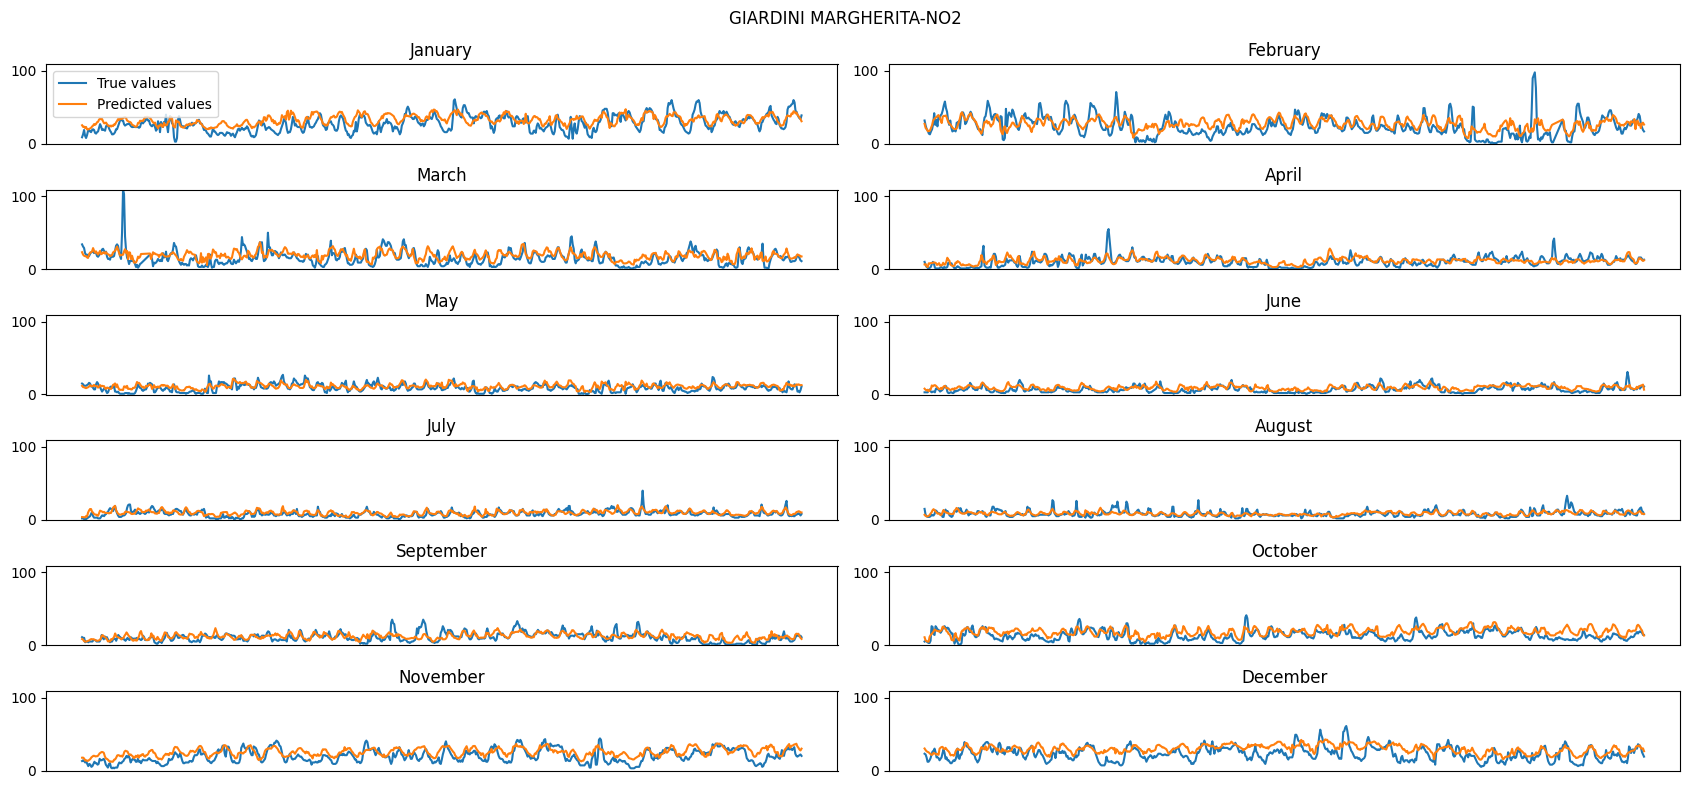

root_mean_squared_error: 0.5929249580272762
r2_score: 0.5012595358448102
mean_absolute_error: 0.43995224039251374
huber: 0.07009167224168777


2025-05-04 20:44:16.808932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
plot_months_predictions(test_sets[station][agent]['y'], rfr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### XGBoost

##### *Models*

In [16]:
xgbr_params = {
    'objective': "reg:absoluteerror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [17]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 250,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.75,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing*

In [21]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_xgbr = 'XGB Regressor'

In [22]:
validation_ratio = 0.1

X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_model = xgb.XGBRegressor(**hour_models[selected_xgbr][1])
xgbr_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.77954
[1]	validation_0-mae:0.75116
[2]	validation_0-mae:0.72533
[3]	validation_0-mae:0.70201
[4]	validation_0-mae:0.68127
[5]	validation_0-mae:0.66203
[6]	validation_0-mae:0.64488
[7]	validation_0-mae:0.62911
[8]	validation_0-mae:0.61531
[9]	validation_0-mae:0.60191
[10]	validation_0-mae:0.59008
[11]	validation_0-mae:0.57931
[12]	validation_0-mae:0.56978
[13]	validation_0-mae:0.56106
[14]	validation_0-mae:0.55300
[15]	validation_0-mae:0.54548
[16]	validation_0-mae:0.53837
[17]	validation_0-mae:0.53195
[18]	validation_0-mae:0.52619
[19]	validation_0-mae:0.52097
[20]	validation_0-mae:0.51657
[21]	validation_0-mae:0.51192
[22]	validation_0-mae:0.50771
[23]	validation_0-mae:0.50376
[24]	validation_0-mae:0.50037
[25]	validation_0-mae:0.49730
[26]	validation_0-mae:0.49397
[27]	validation_0-mae:0.49122
[28]	validation_0-mae:0.48858
[29]	validation_0-mae:0.48612
[30]	validation_0-mae:0.48417
[31]	validation_0-mae:0.48216
[32]	validation_0-mae:0.48030
[33]	validation_0-ma

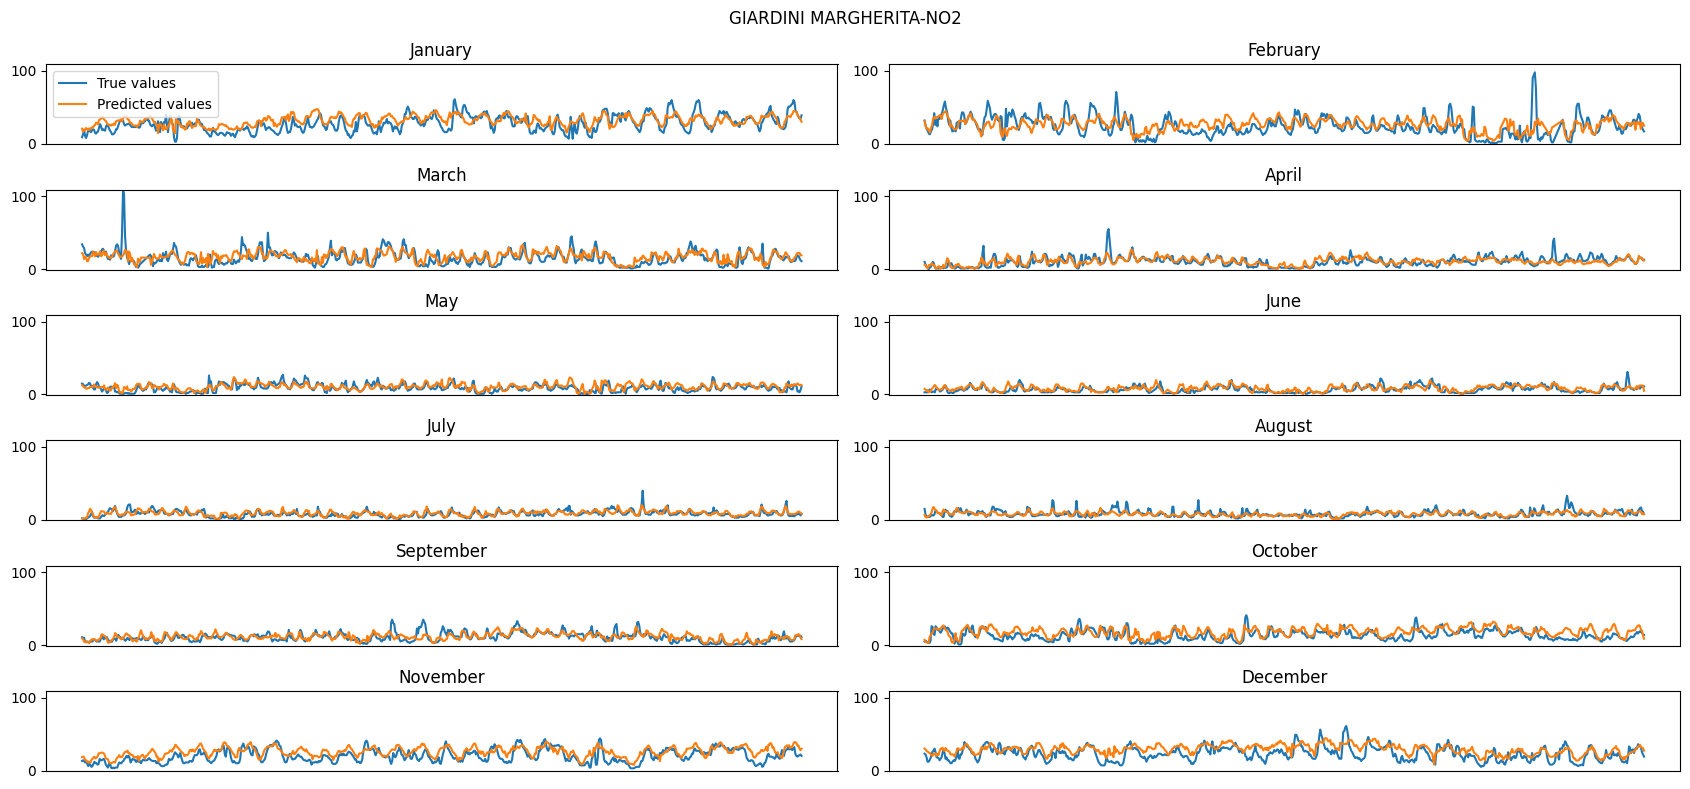

root_mean_squared_error: 0.5794168796341527
r2_score: 0.523725392240904
mean_absolute_error: 0.418073967773765
huber: 0.06620456278324127


In [23]:
plot_months_predictions(test_sets[station][agent]['y'], xgbr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### LSTM

##### *Models*

In [18]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': False # fill nan using bfill()
}

lstm_train_params = {
    'epochs':1,
    'batch_size':64,
}

hour_models['LSTM'] = (build_lstm_model, lstm_params, lstm_train_params, True)

In [19]:
masked_lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error',
    'use_mask': True # apply a mask to nan, instead of filling
}

masked_lstm_train_params = {
    'epochs':50,
    'batch_size':32,
}

hour_models['LSTM-masked'] = (build_lstm_model, masked_lstm_params, masked_lstm_train_params, True)

In [20]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': False
}

lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2'] = (build_lstm_model, lstm2_params, lstm2_train_params, True)


In [21]:
masked_lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

masked_lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2-masked'] = (build_lstm_model, masked_lstm2_params, masked_lstm2_train_params, True)


##### *Testing*

In [28]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_lstm = 'LSTM-masked'

In [29]:
validation_ratio = 0.1
selected_lstm_model = hour_models[selected_lstm]

ts = selected_lstm_model[1]['time_steps']
# lstm_X_train, lstm_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_train, lstm_y_train = None, None
for station in stations:
    if agent in train_sets[station].keys():
        X_train, y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)
        if lstm_X_train is None:
            lstm_X_train = X_train
            lstm_y_train = y_train
        else:
            lstm_X_train = np.concatenate((lstm_X_train, X_train), axis=0)
            lstm_y_train = np.concatenate((lstm_y_train, y_train), axis=0)

lstm_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_X_test, lstm_y_test = create_sequences(lstm_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_train, lstm_X_val, lstm_y_train, lstm_y_val = train_test_split(lstm_X_train, lstm_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

In [30]:
lstm_X_train, lstm_X_val, lstm_y_train, lstm_y_val = train_test_split(lstm_X_train, lstm_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

In [31]:
selected_lstm_model

(<function utils.models.build_lstm_model(time_steps: int, n_features: int, lstm_units: int | list[int], mask_value=-999.0, activation='relu', optimizer='adam', loss='mean_absolute_error', **kwargs)>,
 {'time_steps': 3,
  'n_features': 24,
  'lstm_units': 128,
  'optimizer': <keras.optimizers.optimizer_v2.adam.Adam at 0x758ba02cab00>,
  'loss': 'mean_absolute_error',
  'use_mask': True},
 {'epochs': 50, 'batch_size': 32},
 True)

Epoch 1/50
3256/3256 [==============================] - 16s 4ms/step - loss: 0.4921 - val_loss: 0.4785
Epoch 2/50
3256/3256 [==============================] - 14s 4ms/step - loss: 0.4732 - val_loss: 0.4728
Epoch 3/50
3256/3256 [==============================] - 14s 4ms/step - loss: 0.4669 - val_loss: 0.4679
Epoch 4/50
3256/3256 [==============================] - 14s 4ms/step - loss: 0.4624 - val_loss: 0.4634
Epoch 5/50
3256/3256 [==============================] - 14s 4ms/step - loss: 0.4583 - val_loss: 0.4603
Epoch 6/50
3256/3256 [==============================] - 14s 4ms/step - loss: 0.4551 - val_loss: 0.4607
Epoch 7/50
3256/3256 [==============================] - 14s 4ms/step - loss: 0.4523 - val_loss: 0.4581
Epoch 8/50
3256/3256 [==============================] - 14s 4ms/step - loss: 0.4493 - val_loss: 0.4555
Epoch 9/50
3256/3256 [==============================] - 14s 4ms/step - loss: 0.4460 - val_loss: 0.4528
Epoch 10/50
3256/3256 [==============================] - 14s 4ms/step - l

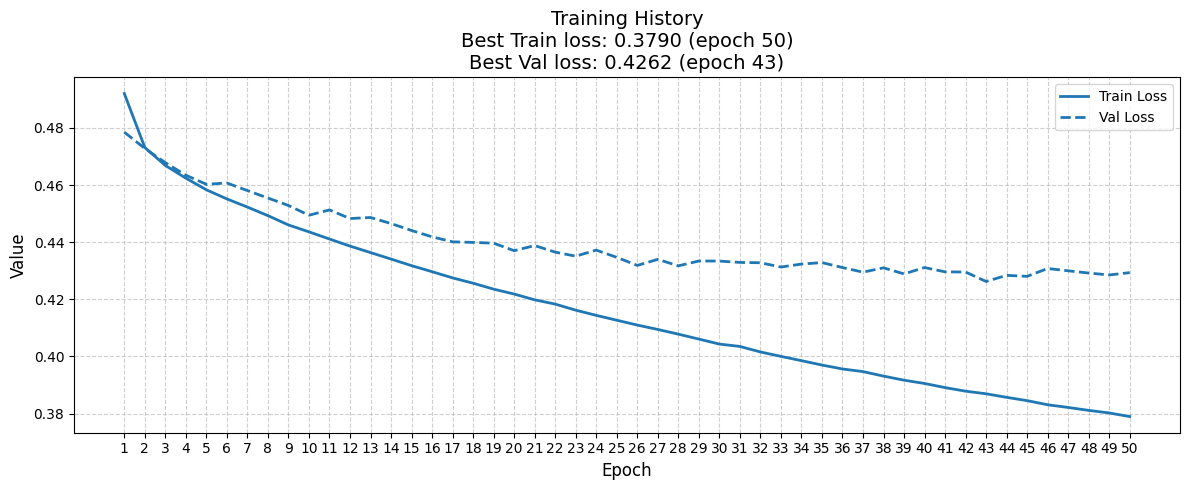

273/273 [==============================] - 2s 2ms/step


In [32]:
selected_lstm_model = hour_models[selected_lstm]
tf.keras.backend.clear_session()  # Reset TensorFlow state
set_random_seed(42) 
lstm_model = selected_lstm_model[0](**selected_lstm_model[1])
lstm_history = lstm_model.fit(
    lstm_X_train,
    lstm_y_train,
    validation_data=(lstm_X_val, lstm_y_val),
    **selected_lstm_model[2],
)
plot_history(lstm_history)
lstm_pred = lstm_model.predict(lstm_X_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)

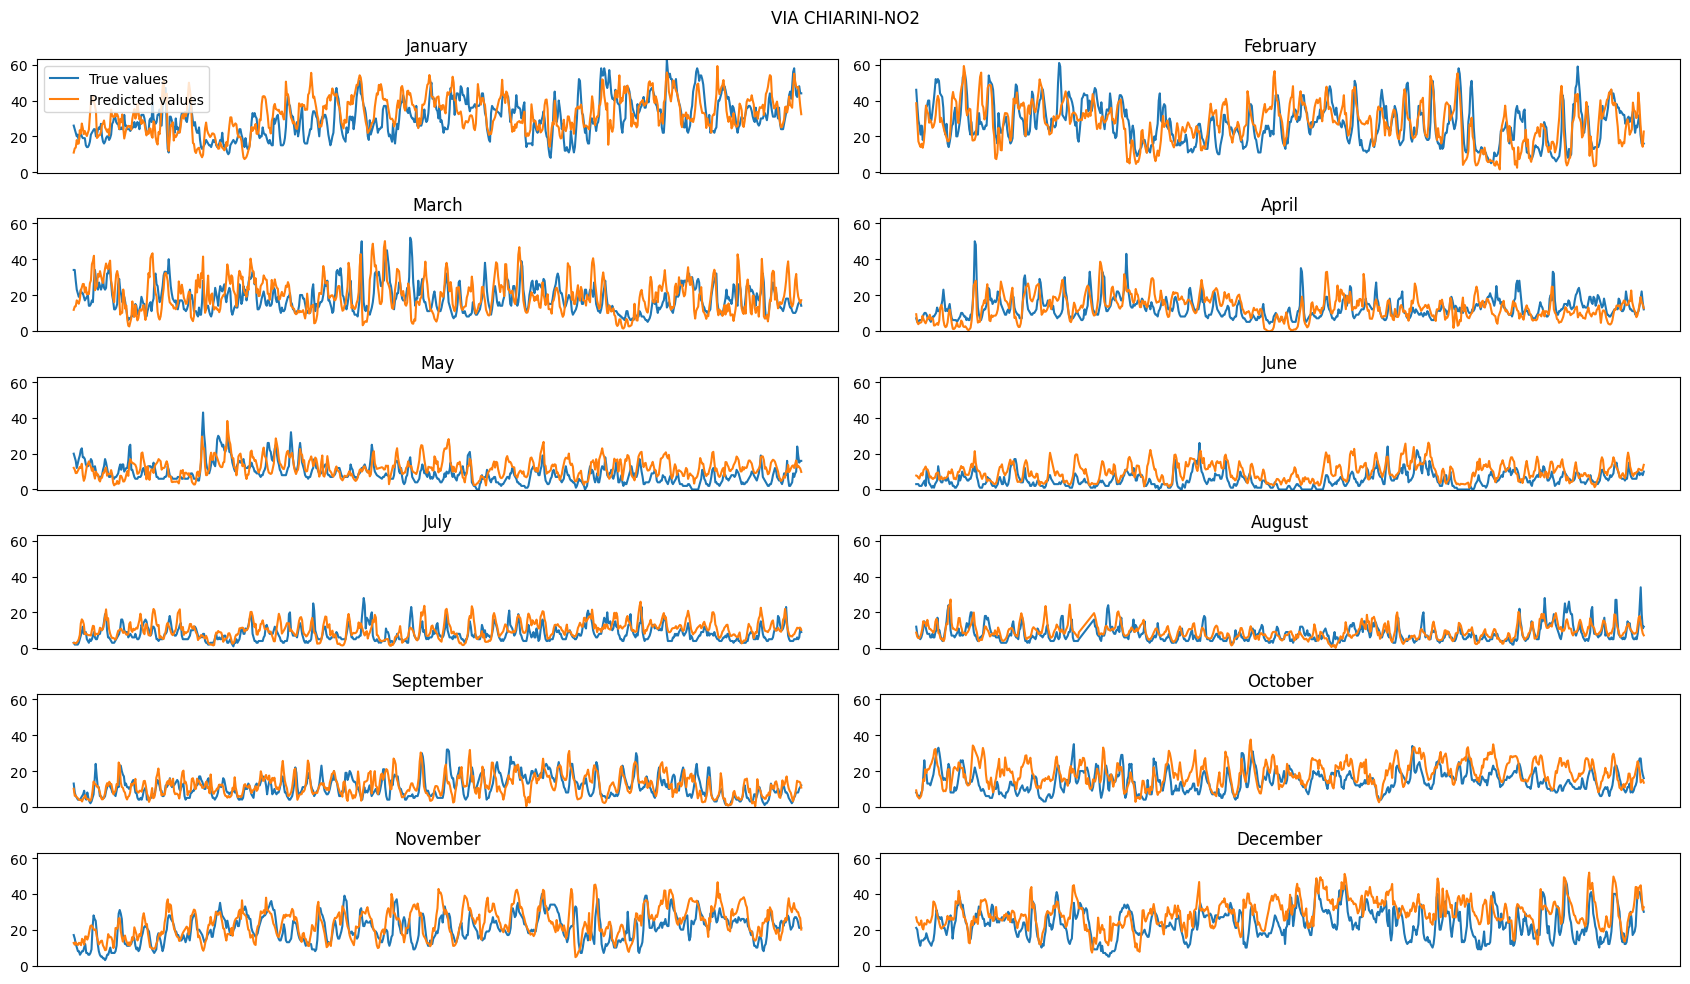

root_mean_squared_error: 0.5690474344312372
r2_score: 0.475020251736066
mean_absolute_error: 0.4347354682793855
huber: 0.06900184601545334


In [33]:
plot_months_predictions(lstm_y_test, lstm_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}', figsize=(17,10))

#### Feed Forward Neural Network

##### *Models*

In [22]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [23]:
bn_ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_params, bn_ffnn_train_params, False)

In [24]:
ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2'] = (build_ffnn_model, ffnn2_params, ffnn2_train_params, False)

In [25]:
bn_ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'batch_norm': True,
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2 BatchNorm'] = (build_ffnn_model, bn_ffnn2_params, bn_ffnn2_train_params, False)

##### *Testing*

In [38]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_ffnn = 'Feed Forward NN 2 BatchNorm'

In [39]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_model = build_ffnn_model(**hour_models[selected_ffnn][1])
ffnn_model.fit(
    merged_train_sets[agent]['x'], 
    merged_train_sets[agent]['y'], 
    **hour_models[selected_ffnn][2]
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/10
4020/4020 [==============================] - 12s 3ms/step - loss: 0.5551
Epoch 2/10
4020/4020 [==============================] - 12s 3ms/step - loss: 0.5397
Epoch 3/10
4020/4020 [==============================] - 12s 3ms/step - loss: 0.5341
Epoch 4/10
4020/4020 [==============================] - 12s 3ms/step - loss: 0.5302
Epoch 5/10
4020/4020 [==============================] - 12s 3ms/step - loss: 0.5294
Epoch 6/10
4020/4020 [==============================] - 12s 3ms/step - loss: 0.5259
Epoch 7/10
4020/4020 [==============================] - 12s 3ms/step - loss: 0.5255
Epoch 8/10
4020/4020 [==============================] - 12s 3ms/step - loss: 0.5219
Epoch 9/10
4020/4020 [==============================] - 12s 3ms/step - loss: 0.5214
Epoch 10/10
273/273 [==============================] - 0s 999us/step


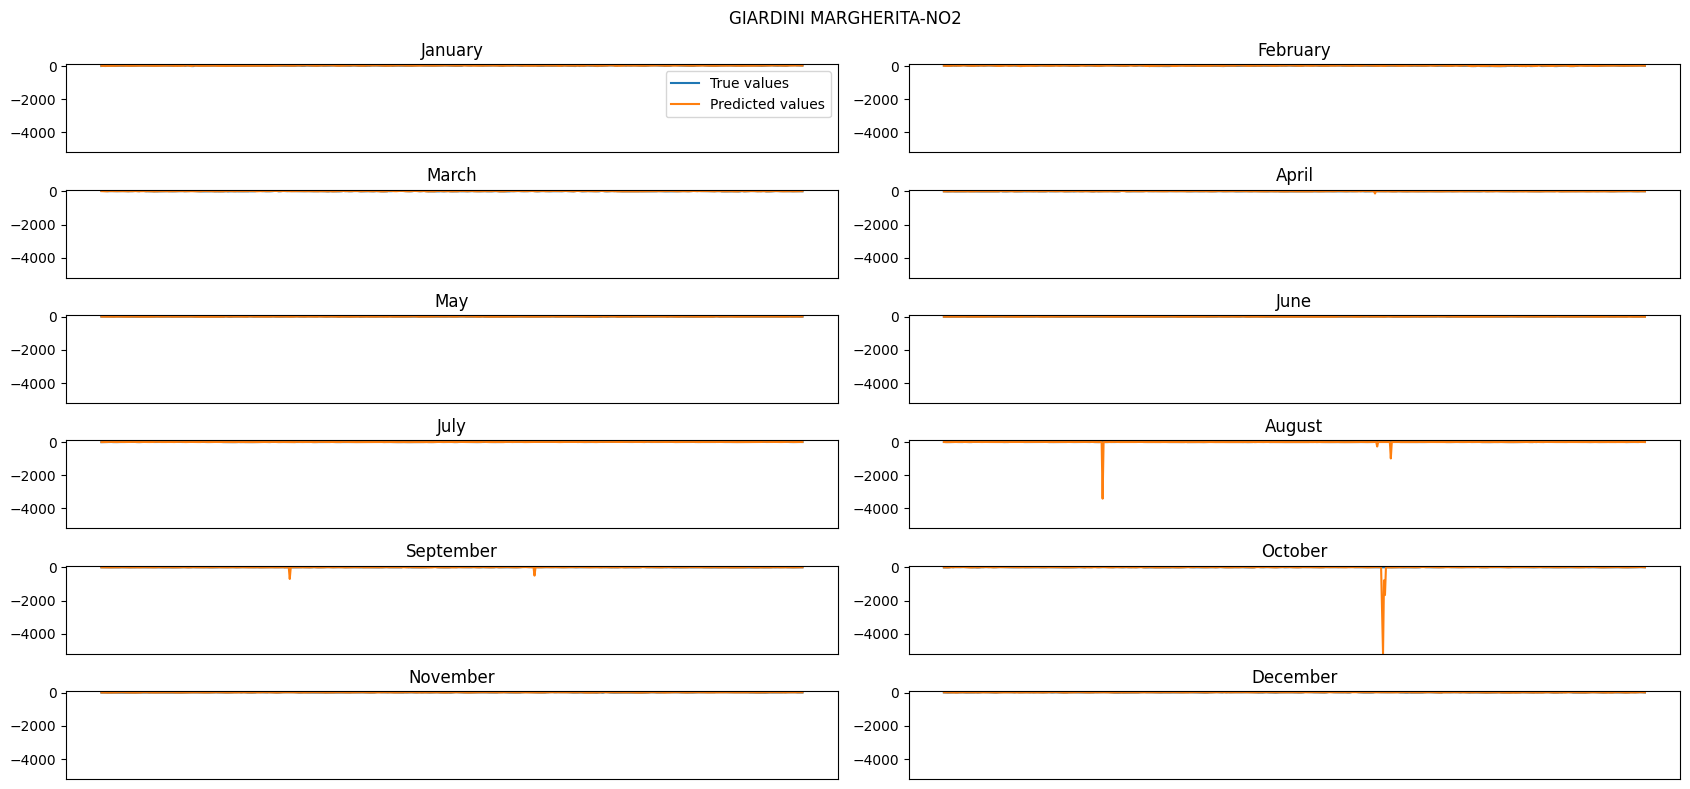

root_mean_squared_error: 6.056568577990536
r2_score: -51.03893742941373
mean_absolute_error: 0.5712061411530621
huber: 0.09662561863660812


In [40]:
plot_months_predictions(test_sets[station][agent]['y'], ffnn_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### Conv1d

##### *Models*

In [26]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D'] = (build_conv_model, conv_params, conv_train_params, True)

In [27]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D 2'] = (build_conv_model, conv2_params, conv2_train_params, True)

In [28]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

hour_models['Conv1D 3'] = (build_conv_model, conv3_params, conv3_train_params, True)

##### *Testing*

In [44]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_conv = 'Conv1D'

In [45]:
validation_ratio = 0.1
selected_conv_model = hour_models[selected_conv]

ts = selected_conv_model[1]['time_steps']
# lstm_X_train, lstm_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_y_train = None, None
for station in stations:
    if agent in train_sets[station].keys():
        X_train, y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)
        if conv_X_train is None:
            conv_X_train = X_train
            conv_y_train = y_train
        else:
            conv_X_train = np.concatenate((conv_X_train, X_train), axis=0)
            conv_y_train = np.concatenate((conv_y_train, y_train), axis=0)

conv_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
conv_X_test, conv_y_test = create_sequences(conv_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_X_val, conv_y_train, conv_y_val = train_test_split(conv_X_train, conv_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

In [46]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_model = build_conv_model(**hour_models[selected_conv][1])
conv_model.fit(
    conv_X_train, 
    conv_y_train, 
    **hour_models[selected_conv][2])
conv_pred = conv_model.predict(conv_X_test)
conv_pred_df = pd.DataFrame(conv_pred, index=conv_y_test.index)

Epoch 1/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.4932
Epoch 2/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.4724
Epoch 3/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.4639
Epoch 4/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.4560
Epoch 5/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.4523
Epoch 6/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.4486
Epoch 7/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.4453
Epoch 8/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.4414
Epoch 9/10
1809/1809 [==============================] - 3s 1ms/step - loss: 0.4387
Epoch 10/10
273/273 [==============================] - 0s 802us/step


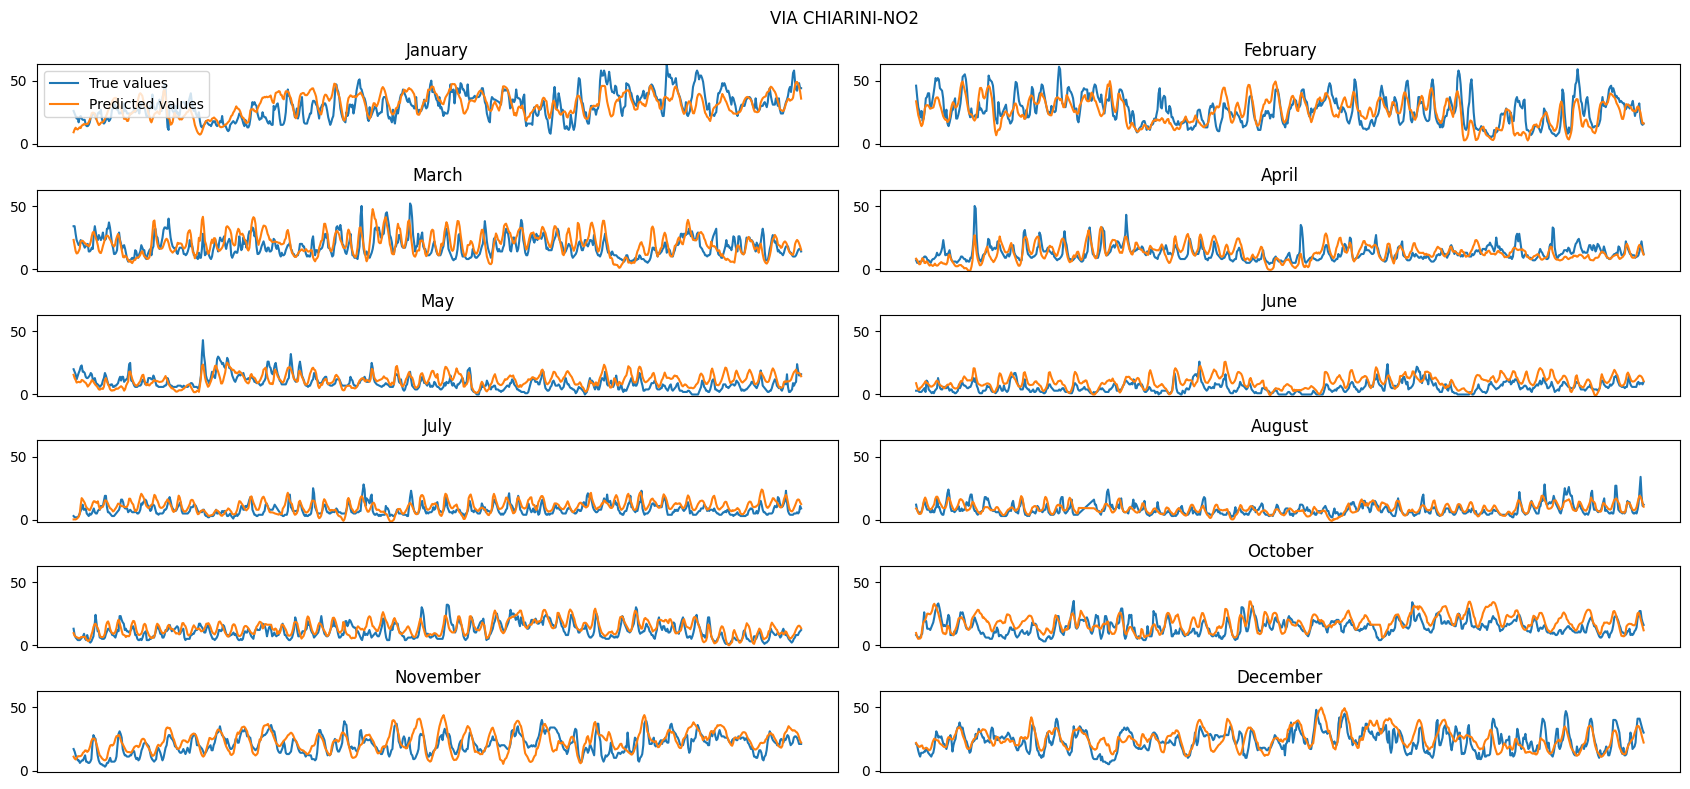

root_mean_squared_error: 0.5096264493775154
r2_score: 0.5789346248632529
mean_absolute_error: 0.3929892016622436
huber: 0.06073237955570221


In [47]:
plot_months_predictions(test_sets[station][agent]['y'], conv_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

### **Daily Models**

In [29]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, uses_sequences:bool|dict)

#### Random Forest Regressor

##### *Models*

In [30]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [31]:
rfr2_params = {
    'n_estimators':150,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [51]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_rfr = 'Random Forest Regressor'

In [52]:
rfr_daily_model = RandomForestRegressor(**daily_models[selected_daily_rfr][1])
rfr_daily_model.fit(merged_train_sets[agent]['x'], merged_train_sets[agent]['y'].to_numpy().ravel())
rfr_daily_pred = rfr_daily_model.predict(test_sets[station][agent]['x'])
rfr_daily_pred_df = pd.DataFrame(rfr_daily_pred, index=test_sets[station][agent]['y'].index)

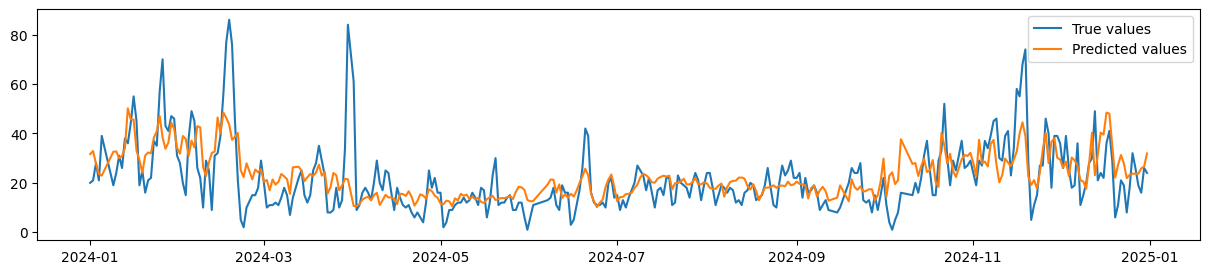

root_mean_squared_error: 0.7236807594977694
r2_score: 0.4197930582142969
mean_absolute_error: 0.5137615558222252
huber: 0.08473100513219833


In [53]:
plot_year_predictions(test_sets[station][agent]['y'], rfr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### XGBoost Regressor

##### *Models*

In [32]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [33]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 150,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr_params, None, False)

##### *Testing*

In [56]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_xgbr = 'XGB Regressor'

In [57]:
validation_ratio = 0.1

X_train, y_train = merged_train_sets[agent]['x'], merged_train_sets[agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_daily_model = xgb.XGBRegressor(**hour_models[selected_daily_xgbr][1])
xgbr_daily_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_daily_pred = xgbr_daily_model.predict(test_sets[station][agent]['x'])
xgbr_daily_pred_df = pd.DataFrame(xgbr_daily_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.75187
[1]	validation_0-mae:0.73052
[2]	validation_0-mae:0.71083
[3]	validation_0-mae:0.69336
[4]	validation_0-mae:0.67836
[5]	validation_0-mae:0.66253
[6]	validation_0-mae:0.64713
[7]	validation_0-mae:0.63332
[8]	validation_0-mae:0.61982
[9]	validation_0-mae:0.60756
[10]	validation_0-mae:0.59755
[11]	validation_0-mae:0.58803
[12]	validation_0-mae:0.57879
[13]	validation_0-mae:0.57101
[14]	validation_0-mae:0.56190
[15]	validation_0-mae:0.55452
[16]	validation_0-mae:0.54502
[17]	validation_0-mae:0.53915
[18]	validation_0-mae:0.53361
[19]	validation_0-mae:0.52671
[20]	validation_0-mae:0.52159
[21]	validation_0-mae:0.51782
[22]	validation_0-mae:0.51225
[23]	validation_0-mae:0.50579
[24]	validation_0-mae:0.49985
[25]	validation_0-mae:0.49677
[26]	validation_0-mae:0.49417
[27]	validation_0-mae:0.49242
[28]	validation_0-mae:0.48909
[29]	validation_0-mae:0.48555
[30]	validation_0-mae:0.48312
[31]	validation_0-mae:0.47873
[32]	validation_0-mae:0.47655
[33]	validation_0-ma

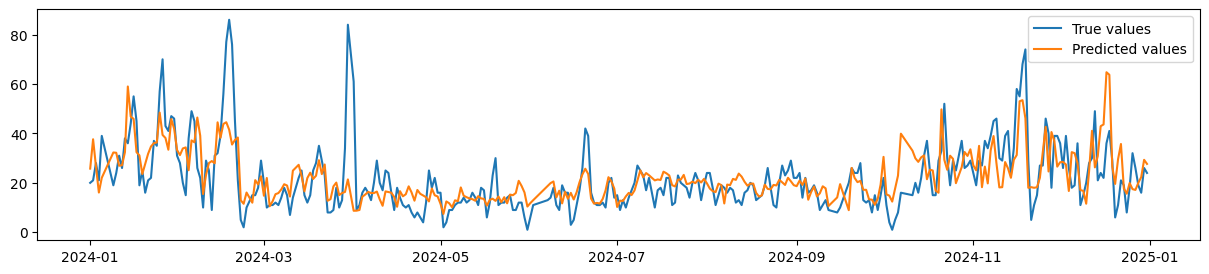

root_mean_squared_error: 0.7254542405201075
r2_score: 0.41694581701327116
mean_absolute_error: 0.5043965733302436
huber: 0.0830104798078537


In [58]:
plot_year_predictions(test_sets[station][agent]['y'], xgbr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### Feed Forward Neural Network

##### *Models*

In [34]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [35]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

##### *Testing*

In [61]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_ffnn = 'Feed Forward NN'

In [62]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_daily_model = build_ffnn_model(**daily_models[selected_daily_ffnn][1])
ffnn_daily_model.fit(
    merged_train_sets[agent]['x'], 
    merged_train_sets[agent]['y'], 
    **daily_models[selected_daily_ffnn][2]
    )
ffnn_daily_pred = ffnn_daily_model.predict(test_sets[station][agent]['x'])
ffnn_daily_pred_df = pd.DataFrame(ffnn_daily_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/20
166/166 [==============================] - 1s 5ms/step - loss: 0.5607
Epoch 2/20
166/166 [==============================] - 1s 5ms/step - loss: 0.5116
Epoch 3/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4864
Epoch 4/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4732
Epoch 5/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4625
Epoch 6/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4485
Epoch 7/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4391
Epoch 8/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4261
Epoch 9/20
166/166 [==============================] - 1s 5ms/step - loss: 0.4216
Epoch 10/20
166/166 [==============================] - 1s 6ms/step - loss: 0.4103
Epoch 11/20
166/166 [==============================] - 1s 6ms/step - loss: 0.4023
Epoch 12/20
166/166 [==============================] - 1s 5ms/step - loss: 0.3940
Epoch 13/20
166/166 [====

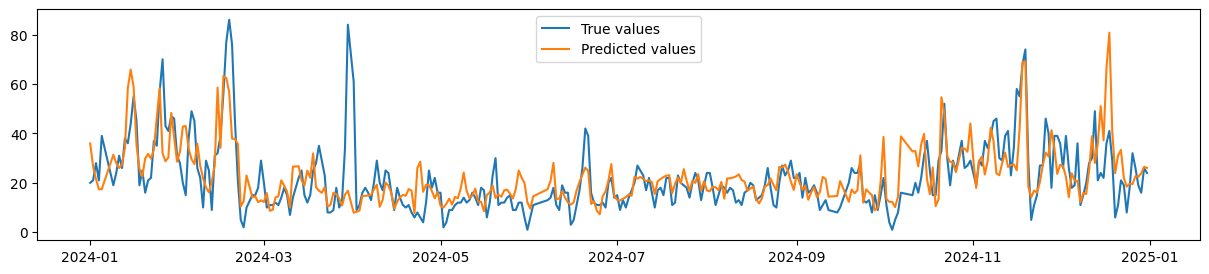

root_mean_squared_error: 0.7522685021586234
r2_score: 0.3730475204491015
mean_absolute_error: 0.5205349973094275
huber: 0.08598779141902924


In [63]:
plot_year_predictions(test_sets[station][agent]['y'], ffnn_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### LSTM

In order to use LSTMs, we need to have sequences/time steps. For the other models, we aggregated the hourly data into a single day, but we could try to go back to hourly inputs aggregated in sequences of 24 hours.

The tests results were not convincing enough to keep experimentating.

## **Agents Evaluations**

### Hourly Models

In [43]:
hour_results = train_models_1_per_agent(
    hour_models, train_sets, merged_train_sets,test_sets,metrics,
    to_execute={
        'agents':'all',
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    random_state=RANDOM_STATE,
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['NO2', 'O3', 'C6H6', 'CO']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'LSTM', 'LSTM-masked', 'LSTM 2', 'LSTM 2-masked', 'Feed Forward NN', 'Feed Forward NN BatchNorm', 'Feed Forward NN 2', 'Feed Forward NN 2 BatchNorm', 'Conv1D', 'Conv1D 2', 'Conv1D 3']
Agent NO2
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> LSTM model
> LSTM-masked model
> LSTM 2 model
> LSTM 2-masked model
> Feed Forward NN model
> Feed Forward NN BatchNorm model
> Feed Forward NN 2 model
> Feed Forward NN 2 BatchNorm model
> Conv1D model
> Conv1D 2 model
> Conv1D 3 model
Agent O3
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> LSTM model
> LSTM-masked model
> LSTM 2 model
> LSTM 2-masked model
> Feed Forward NN model
> Feed Forward NN

We can extract the results from the training phase, and sort the models using their metrics.

In [53]:
hour_extracted_data = training_results_to_dataframe(hour_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
11,GIARDINI MARGHERITA,NO2,Feed Forward NN 2 BatchNorm,0.573335,0.533672,0.421803,0.066645
2,GIARDINI MARGHERITA,NO2,XGB Regressor,0.582046,0.519394,0.419106,0.066418
0,GIARDINI MARGHERITA,NO2,Random Forest Regressor,0.592925,0.501260,0.439952,0.070092
1,GIARDINI MARGHERITA,NO2,Random Forest Regressor 2,0.593988,0.499470,0.441918,0.070473
10,GIARDINI MARGHERITA,NO2,Feed Forward NN 2,0.619335,0.455841,0.468073,0.075560
4,GIARDINI MARGHERITA,NO2,LSTM,0.622329,0.450566,0.456961,0.073618
3,GIARDINI MARGHERITA,NO2,XGB Regressor 2,0.623852,0.447873,0.454869,0.073230
12,GIARDINI MARGHERITA,NO2,Conv1D,0.648437,0.403500,0.478838,0.077701
13,GIARDINI MARGHERITA,NO2,Conv1D 2,0.665399,0.371885,0.479627,0.077941
14,GIARDINI MARGHERITA,NO2,Conv1D 3,0.679284,0.345397,0.490118,0.080039


And we can display the best model for each station-agent

In [46]:
display(hour_extracted_data.loc[hour_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
11,GIARDINI MARGHERITA,NO2,Feed Forward NN 2 BatchNorm,0.573335,0.533672,0.421803,0.066645
16,GIARDINI MARGHERITA,O3,Random Forest Regressor 2,0.373488,0.843324,0.286085,0.040372
57,PORTA SAN FELICE,C6H6,Conv1D,0.571809,0.645052,0.365437,0.056228
64,PORTA SAN FELICE,CO,LSTM,0.635865,0.613321,0.490889,0.080034
38,PORTA SAN FELICE,NO2,Feed Forward NN,0.885164,-0.450289,0.744765,0.129983
79,VIA CHIARINI,NO2,LSTM,0.495923,0.601274,0.381700,0.058605
94,VIA CHIARINI,O3,LSTM,0.328963,0.875363,0.248257,0.033766


for each agent taking the sum of rmse and the avg of r2

In [56]:
per_agent_hour_extracted_data=hour_extracted_data.groupby(['Agent', 'Model']).agg({
    'root_mean_squared_error': 'sum',
    'mean_absolute_error': 'sum',
    'r2_score': 'mean'
}).reset_index()
display(per_agent_hour_extracted_data.sort_values(by=['Agent','root_mean_squared_error']))

,Agent,Model,root_mean_squared_error,mean_absolute_error,r2_score
0,C6H6,Conv1D,0.571809,0.365437,0.645052
7,C6H6,LSTM,0.578686,0.359122,0.636463
11,C6H6,Random Forest Regressor,0.594239,0.376293,0.616660
12,C6H6,Random Forest Regressor 2,0.594878,0.376681,0.615834
13,C6H6,XGB Regressor,0.595727,0.364883,0.614737
1,C6H6,Conv1D 2,0.598090,0.367679,0.611675
5,C6H6,Feed Forward NN 2 BatchNorm,0.604108,0.367918,0.603821
2,C6H6,Conv1D 3,0.604969,0.367939,0.602691
10,C6H6,LSTM-masked,0.610349,0.384424,0.595593
6,C6H6,Feed Forward NN BatchNorm,0.613269,0.379610,0.591714


best model for each agent

In [58]:
display(per_agent_hour_extracted_data.loc[per_agent_hour_extracted_data.groupby(by=['Agent'])['root_mean_squared_error'].idxmin()])

,Agent,Model,root_mean_squared_error,mean_absolute_error,r2_score
0,C6H6,Conv1D,0.571809,0.365437,0.645052
22,CO,LSTM,0.635865,0.490889,0.613321
43,NO2,XGB Regressor,2.058086,1.625355,0.123667
52,O3,LSTM,0.717215,0.546232,0.853028


Apparently, there isn't a particular model that performs well on an agent across all the stations. That being said, the loss values are really similar and with a better fine tuning a certain model might become the best for certain agents.

Even if this results descourage it, trying to define per-agent models, instead of the current station-agent models, might be worth it. In that case, the train set would also become larger because the data from all the stations would be used.

##### **EXAMPLE:** how to eventually try new metrics

In [42]:
from sklearn.metrics import mean_squared_error

metrics.append(mean_squared_error) # even if you append multiple times, the result is written on a dict so there are no duplicates

In [43]:
new_hour_results = update_metrics(hour_results, test_sets, metrics)
new_hour_extracted_data = training_results_to_dataframe(new_hour_results)
new_hour_extracted_data.sort_values(by=['Agent','Model','Station'])

ValueError: Found input variables with inconsistent numbers of samples: [8722, 8707]

### Daily Models

In [47]:
daily_results = train_models_1_per_agent(
    daily_models, train_sets, merged_train_sets, test_sets, metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'Feed Forward NN', 'Feed Forward NN BatchNorm']
Agent PM10
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> Feed Forward NN model
> Feed Forward NN BatchNorm model
Agent PM2.5
> Random Forest Regressor model
> Random Forest Regressor 2 model
> XGB Regressor model
> XGB Regressor 2 model
> Feed Forward NN model
> Feed Forward NN BatchNorm model


In [48]:
daily_extracted_data = training_results_to_dataframe(daily_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(daily_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,PM10,Random Forest Regressor,0.723681,0.419793,0.513762,0.084731
1,GIARDINI MARGHERITA,PM10,Random Forest Regressor 2,0.732278,0.405925,0.524374,0.086563
4,GIARDINI MARGHERITA,PM10,Feed Forward NN,0.736267,0.399436,0.511386,0.084154
2,GIARDINI MARGHERITA,PM10,XGB Regressor,0.741349,0.391116,0.524098,0.086945
5,GIARDINI MARGHERITA,PM10,Feed Forward NN BatchNorm,0.753997,0.370164,0.533708,0.088700
3,GIARDINI MARGHERITA,PM10,XGB Regressor 2,0.759303,0.361267,0.543371,0.090330
10,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,0.733837,0.477108,0.484842,0.079503
7,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor 2,0.739828,0.468536,0.509424,0.083848
6,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor,0.744029,0.462483,0.513059,0.084569
11,GIARDINI MARGHERITA,PM2.5,Feed Forward NN BatchNorm,0.778002,0.412275,0.516146,0.085808


In [49]:
display(daily_extracted_data.loc[daily_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,PM10,Random Forest Regressor,0.723681,0.419793,0.513762,0.084731
10,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,0.733837,0.477108,0.484842,0.079503
12,PORTA SAN FELICE,PM10,Random Forest Regressor,0.707337,0.504747,0.483271,0.078590
22,PORTA SAN FELICE,PM2.5,Feed Forward NN,0.640390,0.601924,0.440325,0.070425
28,VIA CHIARINI,PM10,Feed Forward NN,0.819528,0.348711,0.607180,0.102658


for each agent taking the sum of rmse and the avg of r2

In [59]:
per_agent_daily_extracted_data=daily_extracted_data.groupby(['Agent', 'Model']).agg({
    'root_mean_squared_error': 'sum',
    'mean_absolute_error': 'sum',
    'r2_score': 'mean'
}).reset_index()
display(per_agent_daily_extracted_data.sort_values(by=['Agent','root_mean_squared_error']))

,Agent,Model,root_mean_squared_error,mean_absolute_error,r2_score
2,PM10,Random Forest Regressor,2.253818,1.612361,0.422679
0,PM10,Feed Forward NN,2.275304,1.608748,0.411901
3,PM10,Random Forest Regressor 2,2.282055,1.645454,0.407990
4,PM10,XGB Regressor,2.338167,1.688031,0.378180
1,PM10,Feed Forward NN BatchNorm,2.353689,1.694485,0.371204
5,PM10,XGB Regressor 2,2.379351,1.726334,0.355718
6,PM2.5,Feed Forward NN,1.374227,0.925167,0.539516
9,PM2.5,Random Forest Regressor 2,1.405312,0.983742,0.519325
8,PM2.5,Random Forest Regressor,1.416649,0.990395,0.511664
7,PM2.5,Feed Forward NN BatchNorm,1.436696,0.975185,0.495559


best model for each agent

In [60]:
display(per_agent_daily_extracted_data.loc[per_agent_daily_extracted_data.groupby(by=['Agent'])['root_mean_squared_error'].idxmin()])

,Agent,Model,root_mean_squared_error,mean_absolute_error,r2_score
2,PM10,Random Forest Regressor,2.253818,1.612361,0.422679
6,PM2.5,Feed Forward NN,1.374227,0.925167,0.539516
